# Partie 1 : Caractérisation du réseau de nanosatellites
Scenario: 
Grid of lunar satellites
 *  Duration: 1 year (01 Jul 2022 – 01 Jul 2023)
 *  Orbit: semi-major axis = 3416.9 km, eccentricity = 0.359, inclination = 90.2°
 *  Central elements: RAAN = 237.7°, Argument of Periapsis = 292.9°
 *  Grid size: N x N satellites (Two scenarios: N=3 and N=7)
 *  Perturbations: RAAN and AoP varied around the center in 0.5° increments

 Method: We sample the first 10 hours of each month, collecting 12 windows that span the entire year.

 ***

 Data: Each CSV file contains the orbital coordinates of a single satellite as a time series, giving its position for the first 10 hours (36000 seconds) of each of the 12 months of the year.

File Names: Format "coords_LLO-{}-{}-{}_{}".format(grid_x, grid_y, propagator, month)
 *  grid_x = RAAN grid position (0 to N - 1).
 *  grid_y = Argument of Periapsis grid position (0 to N - 1).
 *  propagator = 2B (Two-Body) or J4 (J4 perturbation + optional 3rd-body).
 *  month = sampled month (1 to 12)

File Content:

Satellite Parameters (header block)
 *  sat1Name → Satellite identifier (e.g., LLO-0-0-2B).
 *  sat1Smaj → Semi-major axis (km).
 *  sat1Ecc → Eccentricity.
 *  sat1Inc → Inclination (deg).
 *  sat1RAAN → Right Ascension of the Ascending Node (deg).
 *  sat1ArgPer → Argument of Periapsis (deg).
 *  sat1TrAnom → True Anomaly at epoch (deg).

Time-Evolving Coordinates (data block)
 *  Time[EpSec] → Elapsed seconds from the scenario epoch.
 *  xF[km], yF[km], zF[km] → Satellite position in the Moon-Fixed frame (rotating with the Moon).
 *  xI[km], yI[km], zI[km] → Satellite position in the ICRF inertial frame (non-rotating, Earth-centered inertial extension).


In [2]:
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from swarm_sim import *   # Import principal : module de simulation

%matplotlib inline 

In [7]:
GRID_SIZE = 7
NB_NODES = GRID_SIZE*GRID_SIZE       # Nombre de satellites (noeuds)
DURATION = 3601    # Nombre total d'échantillons disponibles
REVOLUTION = 1800   # Nombre d'échantillons pour 1 révolution en orbite lunaire
SAMPLE_FREQ = 0.1   # Fréquence d'échantillonnage (Hz) : toutes les 10 secondes
CONNECTION_RANGE = 30000    # Portée de connexion (m)
MONTHS = np.arange(1,13)
PATH = '..\..\data\\v9-grid-7x7-sats-pert\\coords_LLO-'
PROPAGATION = 'J4'
ROW_DATA_START = 7
SAMPLE_STEP = 60    # Fréquence de ré-échantillonnage pour ne pas analyser toutes les topologies (1 sur 12, i.e. toutes les 2 minutes)

# Variables globales pour la génération des figures
TMAX = REVOLUTION/SAMPLE_FREQ # temps maximal échantillonné
IDX = np.arange(0, TMAX, 1/SAMPLE_FREQ) # index converti en secondes

## 1. Formattage des données pour l'analyse
### 1.1 Importation du dataset
Coordonnées (x,y,z) de chaque nanosatellite à chaque pas de temps

In [16]:
PATH = '..\..\data\\v9-grid-7x7-sats-pert\\coords_LLO-'
PROPAGATION = 'J4'
row_data_start = 7
satellites = {}

MONTH = '1'
with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    sat_id = 0
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            df = pd.read_csv(PATH+str(i)+'-'+str(j)+'-'+PROPAGATION+'_'+MONTH+'.csv', skiprows= lambda x: x<row_data_start, header=0)
            satellites[sat_id] = df
            sat_id += 1
            pbar.update(1)

satellites[0]

Extracting data: 100%|██████████| 49/49 [00:01<00:00, 27.00it/s]


,Time[EpSec],xF[km],yF[km],zF[km],xI[km],yI[km],zI[km]
0,0.0,935.146104,-1138.772496,-1619.722874,-439.255210,-668.701929,-2038.307095
1,10.0,938.964472,-1151.552703,-1608.463777,-448.290141,-682.171172,-2031.886334
2,20.0,942.738324,-1164.279347,-1597.129582,-457.304141,-695.608566,-2025.370705
3,30.0,946.467490,-1176.951835,-1585.720824,-466.296789,-709.013486,-2018.760521
4,40.0,950.151804,-1189.569580,-1574.238044,-475.267669,-722.385311,-2012.056103
...,...,...,...,...,...,...,...
3596,35960.0,849.721089,-1366.920524,-1488.179923,-539.609679,-819.093262,-1960.378726
3597,35970.0,851.859720,-1379.322012,-1476.105798,-548.382037,-832.169858,-1952.908854
3598,35980.0,853.958074,-1391.659459,-1463.963017,-557.128887,-845.207750,-1945.348149
3599,35990.0,856.016082,-1403.932331,-1451.752189,-565.849840,-858.206356,-1937.697022


### 1.2 Conversion en objet Swarm (module swarm_sim)
L'objet Swarm est caractérisé, à chaque instant *t*, par la portée de connexion et les positions des noeuds.

In [34]:
swarm_data = {}

with tqdm(total = REVOLUTION, desc = 'Converting to Swarm') as pbar:
    for t in range(REVOLUTION):
        swarm_data[t] = Swarm(
            connection_range = CONNECTION_RANGE, 
            nodes = [Node(id, sat['xF[km]'].iloc[t], sat['yF[km]'].iloc[t], sat['zF[km]'].iloc[t]) for id,sat in satellites.items()]
            )
        pbar.update(1)

swarm = swarm_data[0]
print(swarm)
print(swarm.nodes[0])

Converting to Swarm: 100%|██████████| 1800/1800 [00:05<00:00, 352.58it/s]

Swarm of 49 node(s), connection range: 30000
Node ID 0 (935.1461044540126,-1138.7724963415594,-1619.7228741811743) has 0 neighbor(s)	Group: -1


In [21]:
def plot_nodes(swarm, n_color='blue'):
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')
    x_data = [node.x for node in swarm.nodes]
    y_data = [node.y for node in swarm.nodes]
    z_data = [node.z for node in swarm.nodes]
    ax.scatter(x_data, y_data, z_data, c=n_color, s=50)
    
    
def plot_trajectory(data, sat_id, stop=DURATION, moon=True):
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')
    if moon:
        ax.scatter([0], [0], [0], c='gray', edgecolors='black', s=1000)
    x_data = [swarm.nodes[sat_id].x for t,swarm in data.items() if t<stop]
    y_data = [swarm.nodes[sat_id].y for t,swarm in data.items() if t<stop]
    z_data = [swarm.nodes[sat_id].z for t,swarm in data.items() if t<stop]
    ax.scatter(x_data, y_data, z_data, c='blue', s=50)

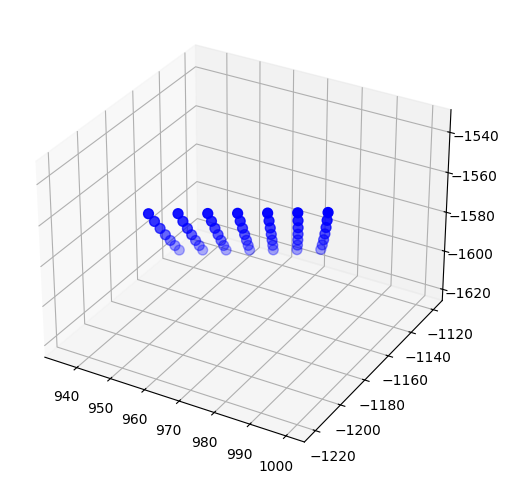

In [35]:
plot_nodes(swarm_data[0])

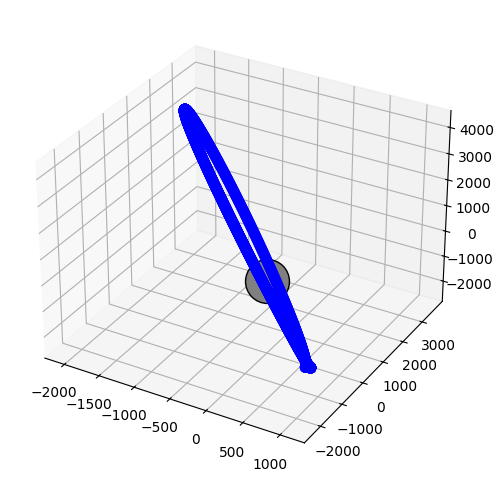

In [36]:
plot_trajectory(swarm_data, sat_id=0)

### 1.3 Création de la topologie : établissement des ISL d'après la portée de connexion

In [8]:
swarm_months = {}

for m in MONTHS:
    print('\nExtracting month', m)
    satellites = {} # Dict(sat_id: DataFrame)
    with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
        sat_id = 0
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                df = pd.read_csv(PATH+str(i)+'-'+str(j)+'-'+PROPAGATION+'_'+str(m)+'.csv', skiprows= lambda x: x<ROW_DATA_START, header=0)
                satellites[sat_id] = df
                sat_id += 1
                pbar.update(1)
            
    swarm_data = {} # Dict{timestamp: Swarm}
    with tqdm(total = REVOLUTION, desc = 'Converting to Swarm') as pbar:
        for t in range(REVOLUTION):
            swarm_data[t] = Swarm(
                connection_range = CONNECTION_RANGE, 
                nodes = [Node(id, sat['xF[km]'].iloc[t], sat['yF[km]'].iloc[t], sat['zF[km]'].iloc[t]) for id,sat in satellites.items()]
                )
            pbar.update(1)
            
    # Ré-échantillonner les topologies (réduit les calculs)
    swarm_topo = {}
    for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
        swarm_topo[t] = swarm_data[t]
        
    neighbor_matrices = {} # Dict{timestamp: matrix}
    with tqdm(total=REVOLUTION/SAMPLE_STEP, desc='Computing neighbor matrices') as pbar:
        for t in swarm_topo.keys():
            neighbor_matrices[t] = swarm_topo[t].neighbor_matrix(weighted=True)
            pbar.update(1)
            
    # Création des graphes associés  
    with tqdm(total=REVOLUTION/SAMPLE_STEP, desc='Generating graphs') as pbar:
        for t in swarm_topo.keys():
            swarm_topo[t].create_graph()
            pbar.update(1)
            
    # Enlever les ISL trop chers de l'essaim (ceux dont le coût est supérieur au coût du plus court chemin)
    with tqdm(total=REVOLUTION/SAMPLE_STEP, desc = 'Removing expensive edges') as pbar:
        for t in swarm_topo.keys():
            swarm_topo[t].remove_expensive_edges()
            pbar.update(1)
            
    swarm_months[m] = swarm_topo


Extracting month 1


Converting to Swarm: 100%|██████████| 1800/1800 [00:03<00:00, 597.12it/s]
Computing neighbor matrices: 100%|██████████| 30/30.0 [00:00<00:00, 385.14it/s]
Generating graphs: 100%|██████████| 30/30.0 [00:01<00:00, 19.27it/s]
Removing expensive edges: 100%|██████████| 30/30.0 [01:49<00:00,  3.64s/it]



Extracting month 2


Converting to Swarm: 100%|██████████| 1800/1800 [00:02<00:00, 630.94it/s]
Computing neighbor matrices: 100%|██████████| 30/30.0 [00:00<00:00, 375.11it/s]
Generating graphs: 100%|██████████| 30/30.0 [00:01<00:00, 19.68it/s]
Removing expensive edges: 100%|██████████| 30/30.0 [01:48<00:00,  3.62s/it]



Extracting month 3


Converting to Swarm: 100%|██████████| 1800/1800 [00:02<00:00, 636.24it/s]
Computing neighbor matrices: 100%|██████████| 30/30.0 [00:00<00:00, 355.15it/s]
Generating graphs: 100%|██████████| 30/30.0 [00:01<00:00, 19.95it/s]
Removing expensive edges: 100%|██████████| 30/30.0 [01:50<00:00,  3.69s/it]



Extracting month 4


Converting to Swarm: 100%|██████████| 1800/1800 [00:02<00:00, 609.63it/s]
Computing neighbor matrices: 100%|██████████| 30/30.0 [00:00<00:00, 359.33it/s]
Generating graphs: 100%|██████████| 30/30.0 [00:01<00:00, 19.15it/s]
Removing expensive edges: 100%|██████████| 30/30.0 [01:50<00:00,  3.67s/it]



Extracting month 5


Converting to Swarm: 100%|██████████| 1800/1800 [00:02<00:00, 610.92it/s]
Computing neighbor matrices: 100%|██████████| 30/30.0 [00:00<00:00, 374.33it/s]
Generating graphs: 100%|██████████| 30/30.0 [00:01<00:00, 19.36it/s]
Removing expensive edges: 100%|██████████| 30/30.0 [01:53<00:00,  3.78s/it]



Extracting month 6


Converting to Swarm: 100%|██████████| 1800/1800 [00:03<00:00, 595.17it/s]
Computing neighbor matrices: 100%|██████████| 30/30.0 [00:00<00:00, 363.17it/s]
Generating graphs: 100%|██████████| 30/30.0 [00:01<00:00, 18.59it/s]
Removing expensive edges: 100%|██████████| 30/30.0 [01:51<00:00,  3.71s/it]



Extracting month 7


Converting to Swarm: 100%|██████████| 1800/1800 [00:02<00:00, 602.67it/s]
Computing neighbor matrices: 100%|██████████| 30/30.0 [00:00<00:00, 354.42it/s]
Generating graphs: 100%|██████████| 30/30.0 [00:01<00:00, 19.28it/s]
Removing expensive edges: 100%|██████████| 30/30.0 [01:51<00:00,  3.73s/it]



Extracting month 8


Converting to Swarm: 100%|██████████| 1800/1800 [00:02<00:00, 609.78it/s]
Computing neighbor matrices: 100%|██████████| 30/30.0 [00:00<00:00, 359.07it/s]
Generating graphs: 100%|██████████| 30/30.0 [00:01<00:00, 19.35it/s]
Removing expensive edges: 100%|██████████| 30/30.0 [01:50<00:00,  3.68s/it]



Extracting month 9


Converting to Swarm: 100%|██████████| 1800/1800 [00:02<00:00, 610.50it/s]
Computing neighbor matrices: 100%|██████████| 30/30.0 [00:00<00:00, 358.30it/s]
Generating graphs: 100%|██████████| 30/30.0 [00:01<00:00, 19.44it/s]
Removing expensive edges: 100%|██████████| 30/30.0 [01:51<00:00,  3.71s/it]



Extracting month 10


Converting to Swarm: 100%|██████████| 1800/1800 [00:02<00:00, 645.52it/s]
Computing neighbor matrices: 100%|██████████| 30/30.0 [00:00<00:00, 378.05it/s]
Generating graphs: 100%|██████████| 30/30.0 [00:01<00:00, 19.69it/s]
Removing expensive edges: 100%|██████████| 30/30.0 [01:51<00:00,  3.72s/it]



Extracting month 11


Converting to Swarm: 100%|██████████| 1800/1800 [00:03<00:00, 582.18it/s]
Computing neighbor matrices: 100%|██████████| 30/30.0 [00:00<00:00, 340.63it/s]
Generating graphs: 100%|██████████| 30/30.0 [00:01<00:00, 19.25it/s]
Removing expensive edges: 100%|██████████| 30/30.0 [01:51<00:00,  3.72s/it]



Extracting month 12


Converting to Swarm: 100%|██████████| 1800/1800 [00:02<00:00, 603.29it/s]
Computing neighbor matrices: 100%|██████████| 30/30.0 [00:00<00:00, 355.46it/s]
Generating graphs: 100%|██████████| 30/30.0 [00:01<00:00, 19.06it/s]
Removing expensive edges: 100%|██████████| 30/30.0 [01:50<00:00,  3.69s/it]


In [11]:
print(swarm_months[1][0].nodes[0])

Node ID 0 (935.1461044540126,-1138.7724963415594,-1619.7228741811743) has 48 neighbor(s)	Group: -1


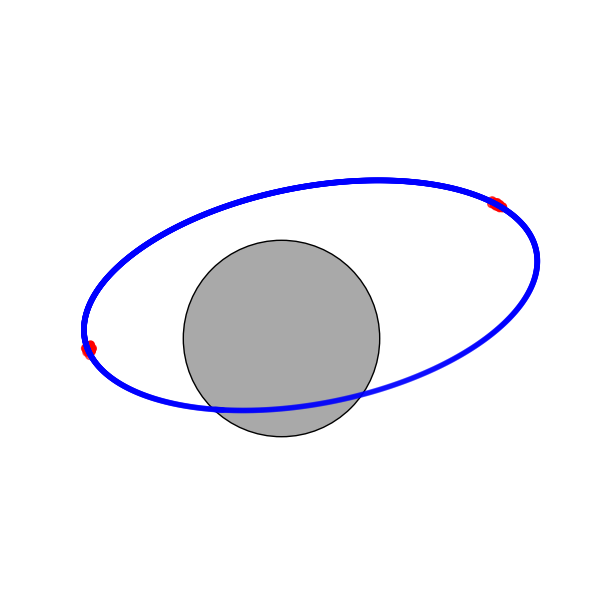

In [9]:
def plot_trajectory(nid, swarm_data, n_color='blue'):
    """
    This function plots the trajectory of a specific node (nid) in a given swarm topology.

    Parameters:
    nid (int): The node ID for which the trajectory needs to be plotted.
    swarm_data (dict): A dictionary containing the swarm data, where the keys are timestamps and the values are Swarm objects.
    n_color (str, optional): The color of the trajectory points. Default is 'blue'.

    Returns:
    None. The function creates a 3D scatter plot to visualize the trajectory of the specified node.
    """
    fig = plt.figure(figsize=(6,6), constrained_layout=True)
    ax = plt.axes(projection='3d')
    ax.set_axis_off()
    x_data = [sw.nodes[nid].x for sw in swarm_data.values()]
    y_data = [sw.nodes[nid].y for sw in swarm_data.values()]
    z_data = [sw.nodes[nid].z for sw in swarm_data.values()]
    ax.scatter(x_data, y_data, z_data, c=n_color, s=10)
    ax.scatter(0,0,0, c='darkgray', edgecolor='black', s=20000)
    for t in (200,1100):
        ax.scatter([node.x for node in swarm_data[t].nodes], 
                   [node.y for node in swarm_data[t].nodes], 
                   [node.z for node in swarm_data[t].nodes], 
                   c='red', 
                   s=30)
    
    
plot_trajectory(0, swarm_data)

## 2. Propriétés du réseau

### 2.1 Mobilité
Vitesse de déplacement de l'essaim

In [14]:
def compute_velocity(sw1, sw2):
    """
    This function computes the swarm velocity from two consecutive swarm topologies.

    Parameters:
    sw1 (Swarm): The first swarm object at time t.
    sw2 (Swarm): The second swarm object at time t+1.

    Returns:
    list: A list containing the node velocities of the swarm. The velocities are computed as the average distance between the nodes of the two swarm topologies at each time step.
    """
    return [n1.compute_dist(n2)*SAMPLE_FREQ for (n1,n2) in zip(sw1.nodes, sw2.nodes)]

for m in MONTHS:
    swarm_data = swarm_months[m]
    swarm_velocity = [np.mean(compute_velocity(swarm_data[t], swarm_data[t+SAMPLE_STEP])) for t in np.arange(0, REVOLUTION-SAMPLE_STEP, SAMPLE_STEP)]
    avg_swarm_velocity = np.mean(swarm_velocity)
    print('Mois', m, '\tVitesse de déplacement moyenne de l\'essaim :', np.round(avg_swarm_velocity,2), 'm/s soit', np.round(avg_swarm_velocity*3.6,2), 'km/h')

Mois 1 	Vitesse de déplacement moyenne de l'essaim : 68.41 m/s soit 246.27 km/h
Mois 2 	Vitesse de déplacement moyenne de l'essaim : 70.0 m/s soit 252.0 km/h
Mois 3 	Vitesse de déplacement moyenne de l'essaim : 69.08 m/s soit 248.67 km/h
Mois 4 	Vitesse de déplacement moyenne de l'essaim : 70.04 m/s soit 252.13 km/h
Mois 5 	Vitesse de déplacement moyenne de l'essaim : 68.73 m/s soit 247.44 km/h
Mois 6 	Vitesse de déplacement moyenne de l'essaim : 70.03 m/s soit 252.12 km/h
Mois 7 	Vitesse de déplacement moyenne de l'essaim : 68.45 m/s soit 246.43 km/h
Mois 8 	Vitesse de déplacement moyenne de l'essaim : 69.99 m/s soit 251.95 km/h
Mois 9 	Vitesse de déplacement moyenne de l'essaim : 69.95 m/s soit 251.83 km/h
Mois 10 	Vitesse de déplacement moyenne de l'essaim : 69.3 m/s soit 249.48 km/h
Mois 11 	Vitesse de déplacement moyenne de l'essaim : 70.02 m/s soit 252.06 km/h
Mois 12 	Vitesse de déplacement moyenne de l'essaim : 68.99 m/s soit 248.36 km/h


In [ ]:
# Distance par rapport à la Lune (pour comparaison)

def compute_moon_dist(sw: Swarm):
    """
    This function computes the distance of each node in the swarm to the Moon.

    Parameters:
    sw (Swarm): The swarm object at time t.
   
    Returns:
    list: A list containing the distance of each node in the swarm to the Moon.
    """
    moon = Node(-1, x=0, y=0, z=0)  # Le système de coordonnées est centré sur la Lune
    return [moon.compute_dist(n) for n in sw.nodes]  

for m in MONTHS:
    swarm_data = swarm_months[m]
    moon_dist = [np.mean(compute_moon_dist(swarm_data[t])) for t in range(REVOLUTION)]
    moon_dist_km = [e/1000 for e in moon_dist]

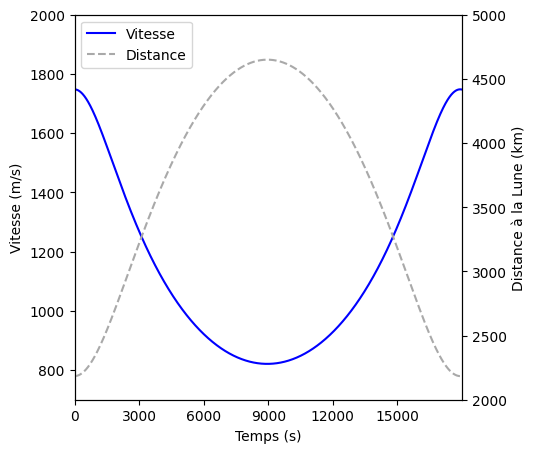

In [11]:
fig, ax = plt.subplots(figsize=(5,5))

l1 = ax.plot(IDX[:-1], swarm_velocity, c='blue', label='Vitesse')
ax.set_xlim(0, TMAX)
ax.set_ylim(700,2000)
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Vitesse (m/s)')
ax.set_xticks(np.arange(0, TMAX, 3000))

ax2 = ax.twinx()
l3 = ax2.plot(IDX, moon_dist_km, c='darkgray', ls='--', label='Distance')
ax2.set_ylim(2000,5000)
ax2.set_ylabel('Distance à la Lune (km)')

lns = l1 + l3
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc='upper left')

Analyse de la mobilité relative des nanosatellites

In [12]:
def compute_distance_matrix(swarm_chunk):
    """
    This function computes the distance matrix of each pair of nodes in a given chunk of time.

    Parameters:
    swarm_chunk (dict): A dictionary containing the swarm data, where the keys are timestamps and the values are Swarm objects.

    Returns:
    distance_matrix (dict): A dictionary containing the distance matrices for each timestamp in the chunk. 
    The distance matrix is a square matrix where the element at position (i,j) represents the distance between nodes i and j at the given timestamp.
    """
    distance_matrix = {}
    with tqdm(total=REVOLUTION, desc='Computing Distance matrix') as pbar:
        for t in range(REVOLUTION):
            distance_matrix[t] = swarm_chunk[t].distance_matrix()
            pbar.update(1)
    return distance_matrix


dm = compute_distance_matrix(swarm_data)
avg_distances_time = [np.mean(dm_time) for dm_time in dm.values()]

Computing Distance matrix: 100%|██████████| 1800/1800 [00:01<00:00, 1161.03it/s]


In [32]:
def compute_relative_velocity(dm1, dm2):
    """
    This function computes the relative velocity of each pair of nodes in two consecutive swarm topologies.

    Parameters:
    dm1 (dict): A dictionary containing the distance matrix of each pair of nodes at time t.
    dm2 (dict): A dictionary containing the distance matrix of each pair of nodes at time t+1.

    Returns:
    list: A list containing the relative velocities of each pair of nodes in the two consecutive swarm topologies.
    """
    return [[abs(e1-e2) for (e1,e2) in zip(dm1[i],dm2[i])] for i in range(len(dm1))]


relative_velocity = [np.mean(compute_relative_velocity(dm[t], dm[t+1])) for t in range(REVOLUTION-1)]
avg_relative_velocity = np.mean(relative_velocity)
print('Vitesse relative moyenne des satellites :', np.round(avg_relative_velocity,2), 'm/s soit', np.round(avg_relative_velocity*3.6,2), 'km/h')

Vitesse relative moyenne des satellites : 102.35 m/s soit 368.46 km/h


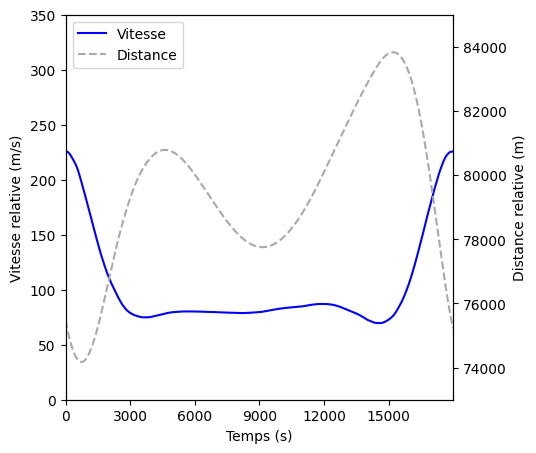

In [31]:
fig, ax = plt.subplots(figsize=(5,5))

l1 = ax.plot(IDX[:-1], relative_velocity, c='blue', label='Vitesse')
ax.set_ylim(0,350)
ax.set_ylabel('Vitesse relative (m/s)')
ax.set_xlim(0,TMAX)
ax.set_xticks(np.arange(0, TMAX, 3000))
ax.set_xlabel('Temps (s)')

ax2 = ax.twinx()
l2 = ax2.plot(IDX, avg_distances_time, c='darkgray', ls='--', label='Distance')
ax2.set_ylabel('Distance relative (m)')
ax2.set_ylim(73000,85000)

lns = l1 + l2
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc='upper left')

In [18]:
# Distance relative moyenne des noeuds sur une période de révolution (m)
np.mean(avg_distances_time)

79426.88622259893

### 2.2 Densité des noeuds

Force des sommets, moyenne et distribution (présenté dans le manuscrit)

In [44]:
# Pour graphes pondérés : calcul de la force (strength) des sommets
strengths = [swarm_weighted[t].strength() for t in range(REVOLUTION)]
avg_strengths = [np.mean(st) for st in strengths]
avg_strength_revolution = np.mean(avg_strengths)
print('Force moyenne sur une révolution :', np.round(avg_strength_revolution,2), 'noeuds')

Force moyenne sur une révolution : 5.14 noeuds


In [88]:
T_HIGH, T_LOW, T_MED = 280, 1090, 1500

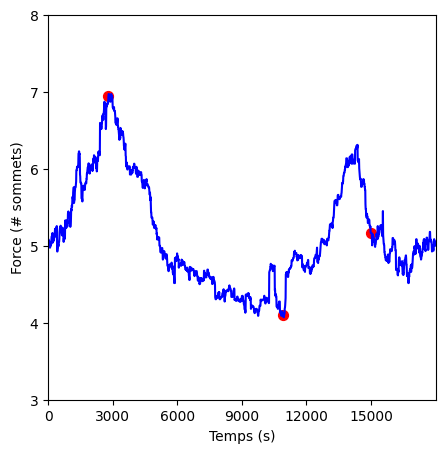

In [89]:
# Evolution temporelle de la force moyenne
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(IDX, avg_strengths, c='blue', label='Degré')
#ax.hlines(y=avg_strength_revolution, xmin=0, xmax=IDX[-1])
ax.scatter([T_HIGH/SAMPLE_FREQ, T_LOW/SAMPLE_FREQ, T_MED/SAMPLE_FREQ], 
            [avg_strengths[T_HIGH],
             avg_strengths[T_LOW],
             avg_strengths[T_MED]],
            c='red',
            s=50)
ax.set_xlim(0, TMAX)
ax.set_ylim(3,8)
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Force (# sommets)')
ax.set_xticks(np.arange(0, TMAX, 3000))

(0.0, 16.0)

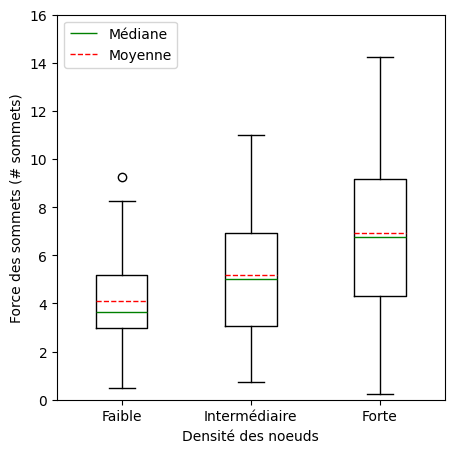

In [67]:
# Distribution des forces
fig,ax = plt.subplots(figsize=(5,5))

bp = ax.boxplot([strengths[T_LOW],
                 strengths[T_MED],
                 strengths[T_HIGH]], 
            vert=True, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )
ax.legend([bp['medians'][0], bp['means'][0]], ['Médiane', 'Moyenne'], loc='upper left')
ax.set_xticklabels(['Faible','Intermédiaire','Forte'])
ax.set_xlabel('Densité des noeuds')
ax.set_ylabel('Force des sommets (# sommets)')
ax.set_ylim(0,16)

Coefficient de clustering

In [71]:
# Coefficients de clustering à portée adaptative (30 km ou 60 km)
coefs_weighted = [swarm_weighted[t].cluster_coef(weight='proba') for t in range(REVOLUTION)]
avg_coef_weighted = [np.mean(list(c.values())) for c in coefs_weighted]
avg_coef_revolution = np.mean(avg_coef_weighted)

print('Coefficient de clustering moyen sur une révolution :', np.round(avg_coef_revolution,2))

Coefficient de clustering moyen sur une révolution : 0.35


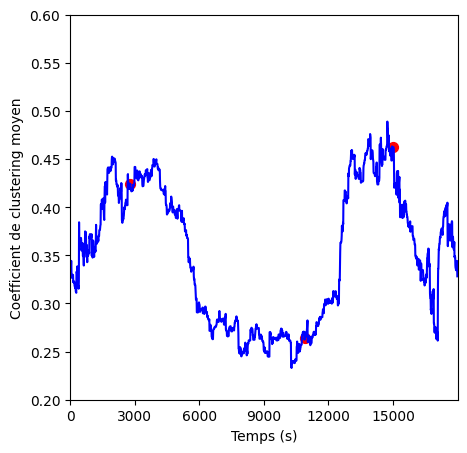

In [92]:
# Evolution temporelle du coefficient de clustering moyen
fig, ax = plt.subplots(figsize=(5,5))

l1 = ax.plot(IDX, avg_coef_weighted, c='blue', label='Clustering')
ax.scatter([T_HIGH/SAMPLE_FREQ, T_LOW/SAMPLE_FREQ, T_MED/SAMPLE_FREQ], 
            [avg_coef_weighted[T_HIGH],
             avg_coef_weighted[T_LOW],
             avg_coef_weighted[T_MED]],
            c='red',
            s=50)
ax.set_xlim(0, TMAX)
ax.set_ylim(0.2,0.6)
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Coefficient de clustering moyen')
ax.set_xticks(np.arange(0, TMAX, 3000))

(-0.05, 1.1)

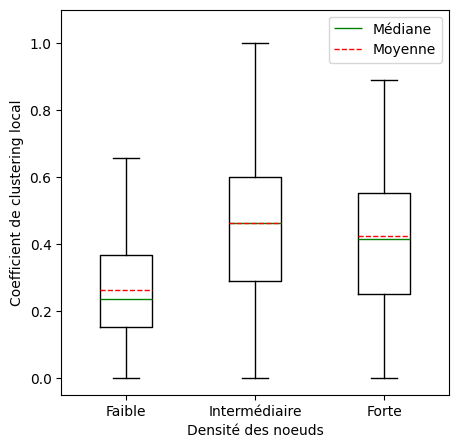

In [96]:
# Distribution des coefficients de clustering
fig,ax = plt.subplots(figsize=(5,5))

bp = ax.boxplot([list(coefs_weighted[T_LOW].values()),
                 list(coefs_weighted[T_MED].values()),
                 list(coefs_weighted[T_HIGH].values())], 
            vert=True, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )
ax.legend([bp['medians'][0], bp['means'][0]], ['Médiane', 'Moyenne'], loc='upper right')
ax.set_xticklabels(['Faible','Intermédiaire','Forte'])
ax.set_xlabel('Densité des noeuds')
ax.set_ylabel('Coefficient de clustering local')
ax.set_ylim(-0.05,1.1)

### 2.3 Disponibilité des ISL

Distribution des temps d'inter-contact (ICT)

In [97]:
def pairwise_ict(nmat: dict):
    """
    This function computes the pairwise Inter-Contact Times (ICT) for each pair of nodes in the swarm.

    Parameters:
    nmat (dict): A dictionary containing the neighbor matrices at each timestamp. 
    The neighbor matrix is a square matrix where the element at position (i,j) represents the adjacency of nodes i and j (0 or 1).

    Returns:
    list: A list containing the pairwise ICTs at each timestamp. 
    """
    total_contact = {}
    for n1 in range(NB_NODES):
        total_contact[n1] = [np.mean([min(nmat[t][n1][n2],1) for t in range(REVOLUTION)]) for n2 in range(NB_NODES)]
    ict = [[(1-n2)*100 for n2 in tc] for tc in total_contact.values()]
    return ict

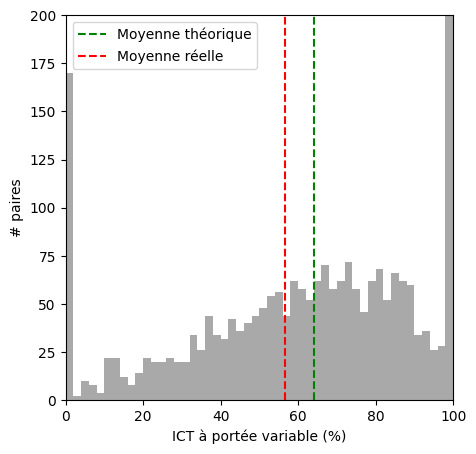

In [98]:
ict_weighted = pairwise_ict(neighbor_matrix_list_weighted)
existing_ict_weighted = [[e for e in row if e<100] for row in ict_weighted]

avg_ict_all = np.mean(ict_weighted)
avg_ict_exist = np.mean([np.mean(row) for row in existing_ict_weighted])


plt.figure(figsize=(5,5))
plt.hist([ e for row in ict_weighted for e in row], bins=50, color='darkgray')
plt.vlines(x=avg_ict_all, ymin=0, ymax=200, color='green', ls='--', label='Moyenne théorique')
plt.vlines(x=avg_ict_exist, ymin=0, ymax=200, color='red', ls='--', label='Moyenne réelle')

plt.xlabel('ICT à portée variable (%)')
plt.ylabel('# paires')
plt.xlim(0,100)
plt.ylim(0,200)
plt.legend()

(-4.0, 104.0)

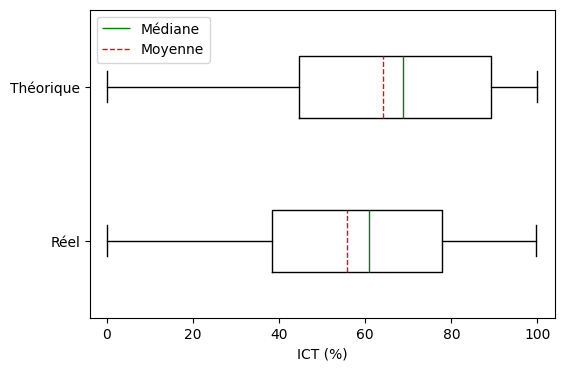

In [100]:
# Distribution des ICT
fig,ax = plt.subplots(figsize=(6,4))

bp = ax.boxplot([[e for row in existing_ict_weighted for e in row],
                 [e for row in ict_weighted for e in row]], 
            vert=False, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )

ax.legend([bp['medians'][0], bp['means'][0]], ['Médiane', 'Moyenne'], loc='upper left')
ax.set_yticklabels(['Réel','Théorique'])
#ax.set_xlabel('Essaim')
ax.set_xlabel('ICT (%)')
ax.set_xlim(-4,104)

In [103]:
print('ICT moyen théorique :', np.round(np.mean(ict_weighted),2),'%')
print('ICT moyen réel :', np.round(np.mean([e for row in existing_ict_weighted for e in row]),2),'%')

ICT moyen théorique : 64.05 %
ICT moyen réel : 55.81 %


Temps d'isolement

In [118]:
def isolation_time(degrees: dict):
    """
    This function calculates the isolation time for each node in the swarm.

    Parameters:
    degrees (dict): A dictionary containing the degree of each node at each timestamp. The degree is the number of connections a node has with other nodes in the swarm.

    Returns:
    iso (dict): A dictionary containing the isolation time for each node. The isolation time is the percentage of time a node is isolated (i.e., has no connections) during the simulation.
    """
    iso = {}
    for nid in range(NB_NODES):
        degs = [degrees[t][nid] for t in range(REVOLUTION)]
        iso[nid] = len([e for e in degs if e==0])/REVOLUTION*100
    return iso


iso_plain = isolation_time(degrees_plain)
iso_weighted = isolation_time(degrees_weighted)

(-4.0, 104.0)

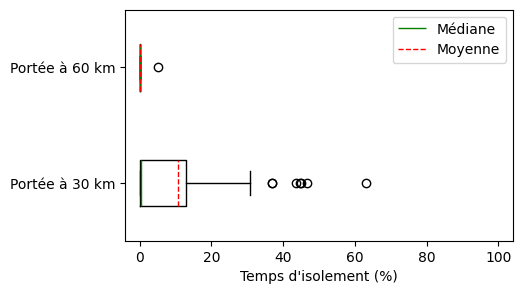

In [120]:
# Distribution du temps d'isolement
fig,ax = plt.subplots(figsize=(5,3))

bp = ax.boxplot([list(iso_plain.values()),
                 list(iso_weighted.values())], 
            vert=False, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )

ax.legend([bp['medians'][0], bp['means'][0]], ['Médiane', 'Moyenne'], loc='upper right')
ax.set_yticklabels(['Portée à 30 km','Portée à 60 km'])
ax.set_xlabel('Temps d\'isolement (%)')
ax.set_xlim(-4,104)

Composantes connexes

In [121]:
nb_cc_plain = [nx.number_connected_components(swarm_plain[t].graph) for t in range(REVOLUTION)]
nb_cc_weighted = [nx.number_connected_components(swarm_weighted[t].graph) for t in range(REVOLUTION)]

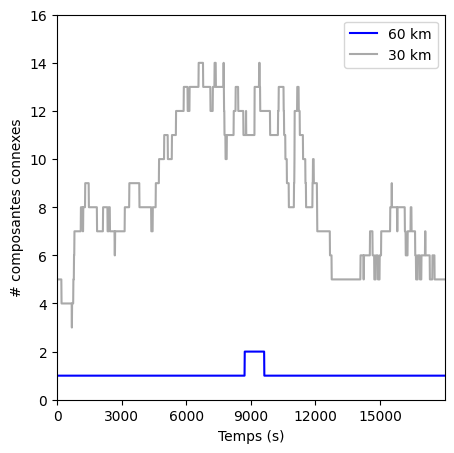

In [124]:
# Evolution temporelle du nombre de composantes connexes
plt.figure(figsize=(5,5))
plt.plot(IDX, nb_cc_weighted, c='blue', label='60 km')
plt.plot(IDX, nb_cc_plain, c='darkgray', label='30 km')
plt.xlabel('Temps (s)')
plt.ylabel('# composantes connexes')
plt.xlim(0,TMAX)
plt.ylim(0,16)
plt.xticks(np.arange(0, TMAX, 3000))
plt.legend()